#### This notebook is used to train a character recongition from input image using MobileNets 

In [1]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

### Visualize dataset

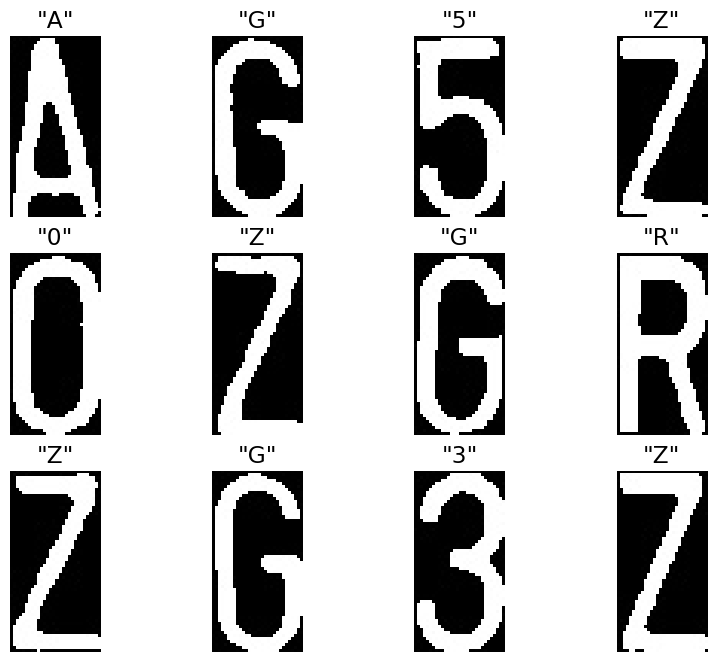

In [2]:
dataset_paths = glob.glob("character_gen2/*/**.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)    


## Data pre-processing

In [3]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes6.npy', lb.classes_)

[INFO] Find 1643 images with 33 classes


In [4]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [5]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

## Initialize MobileNets architecture with pre-trained weight

In [6]:
# Create our model with pre-trained MobileNetV2 architecture from imagenet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(output_shape, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [9]:
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 66

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 10, 10, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 10, 10, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 10, 10, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 10, 10, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 5, 5, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 5, 5, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 5, 5, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 5, 5, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 5, 5, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 5, 5, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 5, 5, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 5, 5, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 3, 3, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 3, 3, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 3, 3, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 3, 3, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [11]:
'''@tf.function
def traceme(x):
    return model(x)

logdir = "log"
writer = tf.summary.create_file_writer(logdir)
tf.summary.trace_on(graph=True, profiler=True)
# Forward pass
#traceme(tf.zeros((1, 28, 28, 1)))
with writer.as_default():
    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=logdir)'''

'@tf.function\ndef traceme(x):\n    return model(x)\n\nlogdir = "log"\nwriter = tf.summary.create_file_writer(logdir)\ntf.summary.trace_on(graph=True, profiler=True)\n# Forward pass\n#traceme(tf.zeros((1, 28, 28, 1)))\nwith writer.as_default():\n    tf.summary.trace_export(name="model_trace", step=0, profiler_outdir=logdir)'

## Train model

In [13]:
from datetime import datetime
BATCH_SIZE = 50

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="License_character_recognition6.h5", verbose=1, save_weights_only=True)
                ]

result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS,
                   callbacks=[tensorboard_callback])

Epoch 1/66
29/29 [==============================] - 5s 181ms/step - loss: 2.2633 - accuracy: 0.4237 - val_loss: 2.8087 - val_accuracy: 0.1636
Epoch 2/66
29/29 [==============================] - 5s 186ms/step - loss: 1.4943 - accuracy: 0.6190 - val_loss: 2.3230 - val_accuracy: 0.3333
Epoch 3/66
29/29 [==============================] - 6s 193ms/step - loss: 1.0458 - accuracy: 0.7374 - val_loss: 2.0840 - val_accuracy: 0.3879
Epoch 4/66
29/29 [==============================] - 5s 184ms/step - loss: 0.7637 - accuracy: 0.8200 - val_loss: 1.9847 - val_accuracy: 0.4970
Epoch 5/66
29/29 [==============================] - 5s 183ms/step - loss: 0.5862 - accuracy: 0.8592 - val_loss: 1.8963 - val_accuracy: 0.5273
Epoch 6/66
29/29 [==============================] - 5s 186ms/step - loss: 0.4586 - accuracy: 0.8859 - val_loss: 1.6784 - val_accuracy: 0.5273
Epoch 7/66
29/29 [==============================] - 5s 187ms/step - loss: 0.3344 - accuracy: 0.9279 - val_loss: 1.6790 - val_accuracy: 0.5394
Epoch 

29/29 [==============================] - 6s 198ms/step - loss: 0.0400 - accuracy: 0.9895 - val_loss: 0.0179 - val_accuracy: 0.9939
Epoch 59/66
29/29 [==============================] - 6s 199ms/step - loss: 0.0389 - accuracy: 0.9916 - val_loss: 0.0181 - val_accuracy: 0.9939
Epoch 60/66
29/29 [==============================] - 6s 200ms/step - loss: 0.0422 - accuracy: 0.9916 - val_loss: 0.0213 - val_accuracy: 0.9939
Epoch 61/66
29/29 [==============================] - 6s 200ms/step - loss: 0.0325 - accuracy: 0.9930 - val_loss: 0.0188 - val_accuracy: 0.9939
Epoch 62/66
29/29 [==============================] - 6s 202ms/step - loss: 0.0450 - accuracy: 0.9902 - val_loss: 0.0156 - val_accuracy: 0.9939
Epoch 63/66
29/29 [==============================] - 6s 195ms/step - loss: 0.0383 - accuracy: 0.9895 - val_loss: 0.0130 - val_accuracy: 0.9939
Epoch 64/66
29/29 [==============================] - 6s 202ms/step - loss: 0.0540 - accuracy: 0.9881 - val_loss: 0.0111 - val_accuracy: 0.9939
Epoch 65/66

## Visualize training result

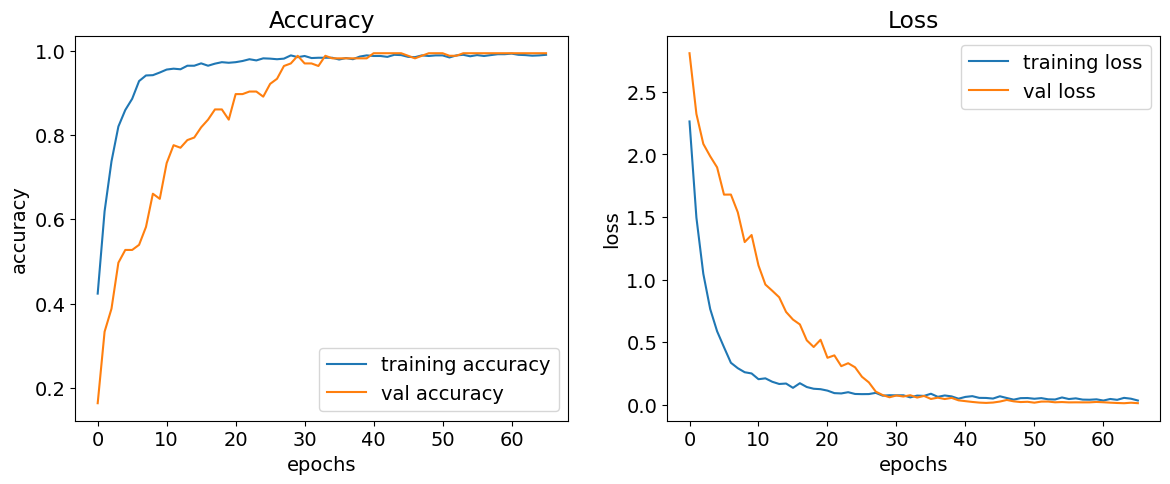

In [14]:

fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig("Training_result6.jpg",dpi=300)

In [15]:
# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition6.json", "w") as json_file:
  json_file.write(model_json)

## The End!